In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.sde import BrownianSDE
from sdebridge.utils import *

plt.style.use('ggplot')

## 1 Dimensional

In [3]:
d = 1
sde = BrownianSDE(dimension=d, num_steps=100)
bridge = DiffusionBridge(sde=sde, rng=jax.random.PRNGKey(0))

In [4]:
%timeit forward_brownian_motion = bridge.simulate_forward_process(initial_val=jnp.tile(jnp.array([[0.0]]), reps=(32, 1)))
# forward_brownian_motion = bridge.simulate_forward_process(initial_val=jnp.tile(jnp.array([[0.0]]), reps=(32, 1)))
# print(forward_brownian_motion["trajectories"].shape)
# print(forward_brownian_motion["scaled_stochastics"].shape)
# for i in range(32):
#     plt.plot(forward_brownian_motion["trajectories"][i, :, 0])

423 µs ± 57 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
setup_params = {
    "network": {"out_dim": sde.d,
                "time_embedding_dim": 64,
                "embedding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [32, 32],
                "decoder_layer_dims": [32, 32],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 20,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_state = bridge.learn_p_score(initial_val=jnp.array([0.0]), 
                                     normalized=False,
                                     setup_params=setup_params)

Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

In [5]:
setup_params = {
    "network": {"out_dim": sde.d,
                "time_embedding_dim": 64,
                "embedding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [32, 32],
                "decoder_layer_dims": [32, 32],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 20,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=jnp.array([0.0]),
                                               terminal_val=jnp.array([2.0]),
                                               score_p=jax.tree_util.Partial(eval_score, state=score_p_state),
                                               setup_params=setup_params)

Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

[ 191650796 2138614886]


Hello world


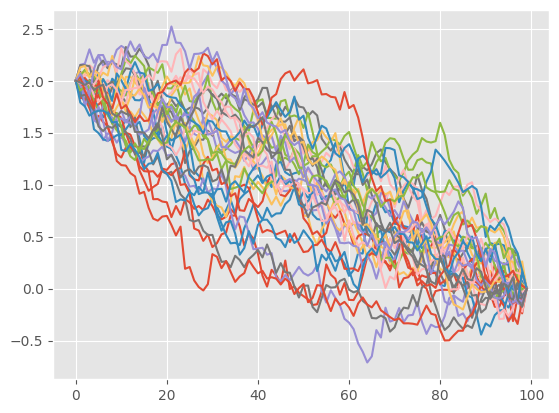

In [40]:
score_p = jax.tree_util.Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=jnp.tile(jnp.array([[0.0]]), reps=(32, 1)), 
                                                           terminal_val=jnp.tile(jnp.array([[2.0]]), reps=(32, 1)),
                                                           score_p=score_p)
bridge.rng = backward_brownian_bridge["rngs"][-1]   # !!! Manually update the rng is necessary now.
for i in range(32):
    plt.plot(backward_brownian_bridge["trajectories"][i, :, 0])

Hello world


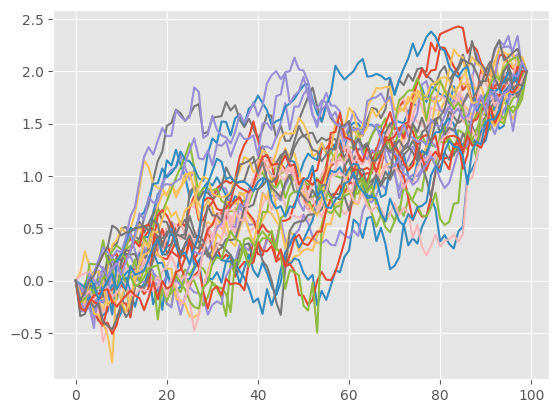

In [26]:
score_h = jax.tree_util.Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=jnp.tile(jnp.array([[0.0]]), reps=(32, 1)), 
                                                         terminal_val=jnp.tile(jnp.array([[2.0]]), reps=(32, 1)),
                                                         score_h=score_h)
bridge.rng = forward_brownian_bridge["rngs"][-1]
for i in range(32):
    plt.plot(forward_brownian_bridge["trajectories"][i, :, 0])

## 2 Dimensional

### Learn the transition density of $X_t$

In [3]:
d = 2
sde = BrownianSDE(dimension=d, num_steps=100)
bridge = DiffusionBridge(sde=sde)
rng = jax.random.PRNGKey(1)

(32, 100, 2)


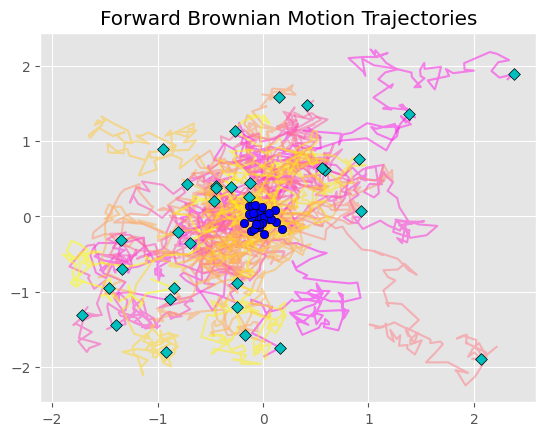

In [4]:
forward_brownian_motion = bridge.simulate_forward_process(initial_val=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)), rng=rng)
print(forward_brownian_motion["trajectories"].shape)
plot_2d_trajectories(forward_brownian_motion["trajectories"], title="Forward Brownian Motion Trajectories")

In [5]:
setup_params = {
    "network": {"out_dim": sde.d,
                "time_embedding_dim": 64,
                "embedding_dim": 64,
                "act": 'gelu',
                "encoder_layer_dims": [64, 64],
                "decoder_layer_dims": [64, 64],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_state = bridge.learn_p_score(initial_val=jnp.array([0.0, 0.0]), 
                                     setup_params=setup_params,
                                     rng=rng)

Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

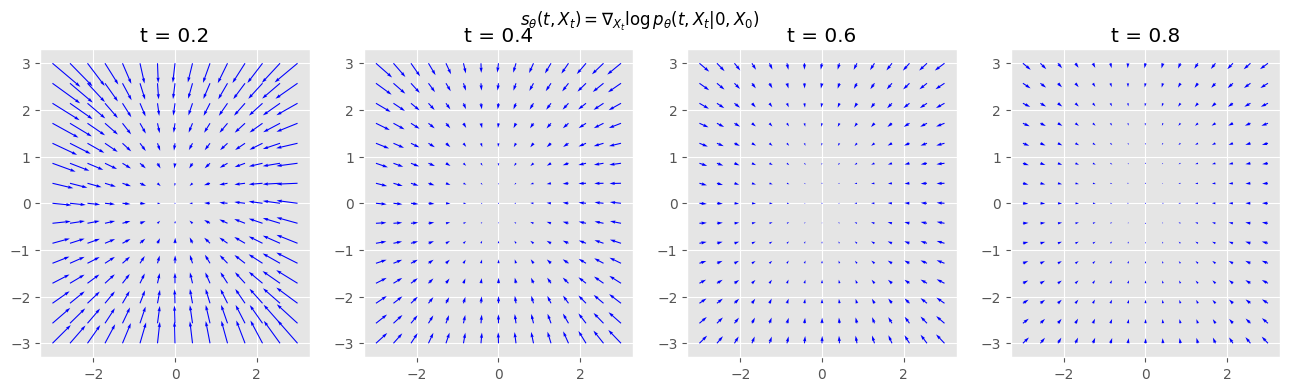

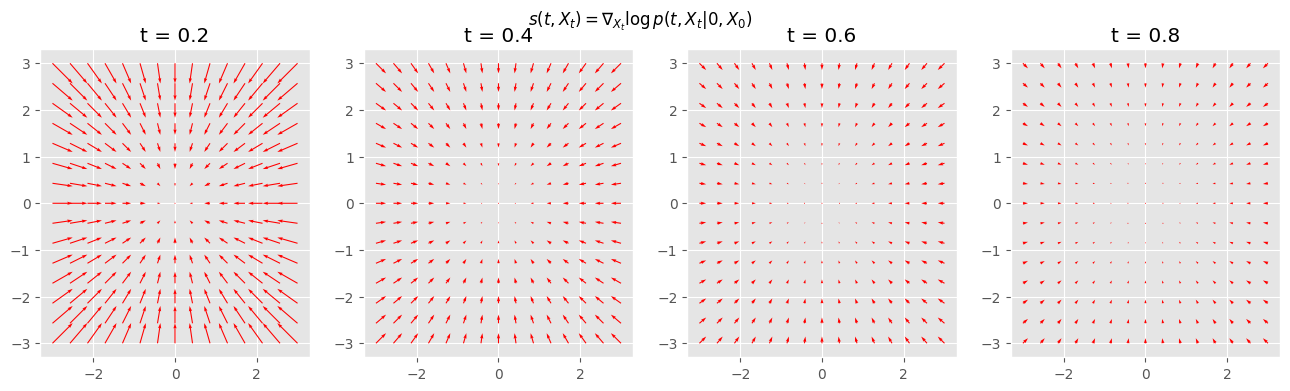

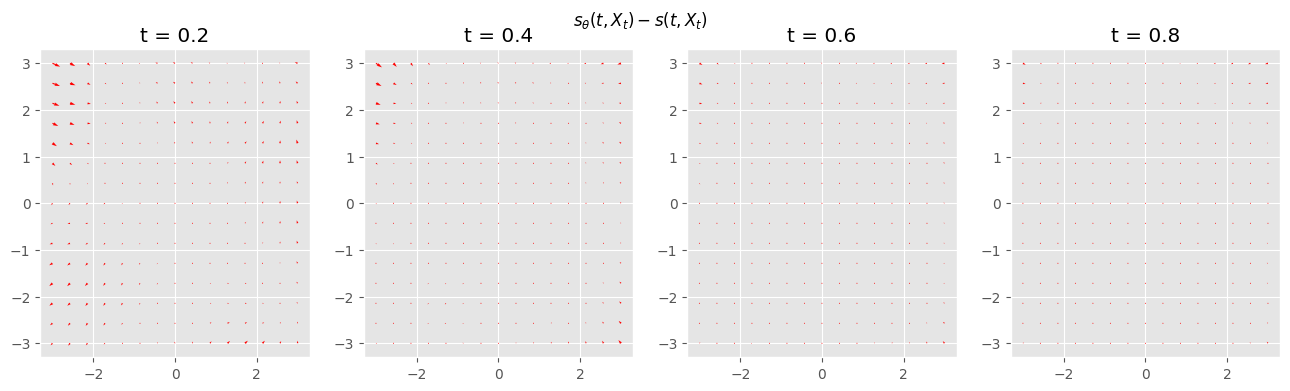

In [6]:
plot_2d_vector_field(X=lambda x, t: eval_score(score_p_state, x, t),
                     X_ref=None,
                     xs=jnp.linspace(-3.0, 3.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s_{\theta}(t, X_t)=\nabla_{X_t}\log p_{\theta}(t, X_t|0, X_0)$",
                     scale=200)

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0: -(x-x0)/t,
                     xs=jnp.linspace(-3.0, 3.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s(t, X_t)=\nabla_{X_t}\log p(t,X_t|0,X_0)$",
                     scale=200,
                     x0=jnp.array([0.0, 0.0]))

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0: eval_score(score_p_state, x, t) - (-(x-x0)/t),
                     xs=jnp.linspace(-3.0, 3.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s_{\theta}(t, X_t) - s(t, X_t)$",
                     scale=200,
                     x0=jnp.array([0.0, 0.0]))

### Use learned transition score to simulate the backward bridge

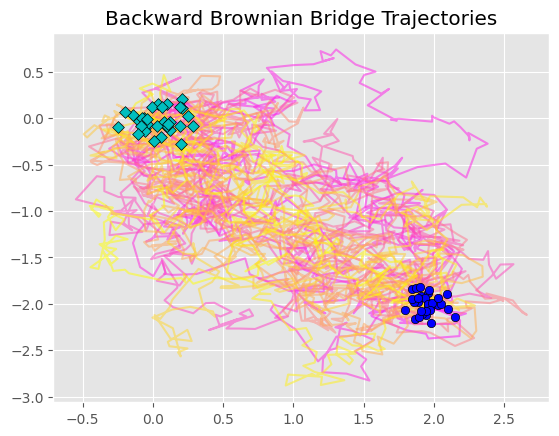

In [7]:
score_p = jax.tree_util.Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)), 
                                                           terminal_val=jnp.tile(jnp.array([[2.0, -2.0]]), reps=(32, 1)),
                                                           score_p=score_p,
                                                           rng=rng)
plot_2d_trajectories(backward_brownian_bridge["trajectories"], title="Backward Brownian Bridge Trajectories")

### Learn the transition density of the forward bridge from the simulated backward bridge

In [13]:
setup_params = {
    "network": {"out_dim": sde.d,
                "time_embedding_dim": 64,
                "embedding_dim": 64,
                "act": 'leaky_relu',
                "encoder_layer_dims": [64, 64],
                "decoder_layer_dims": [64, 64],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 50,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=jnp.array([0.0, 0.0]),
                                               terminal_val=jnp.array([2.0, 0.0]),
                                               score_p=score_p,
                                               setup_params=setup_params,
                                               rng=rng)

Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

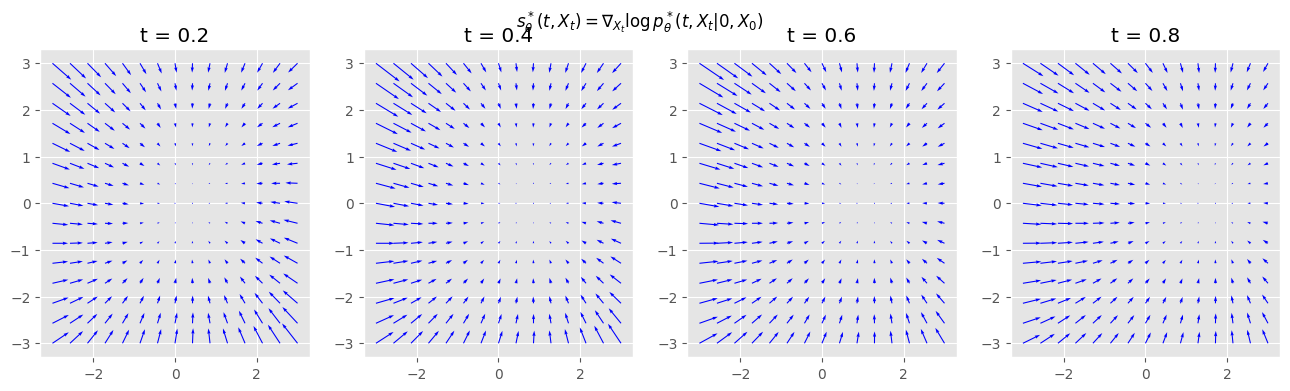

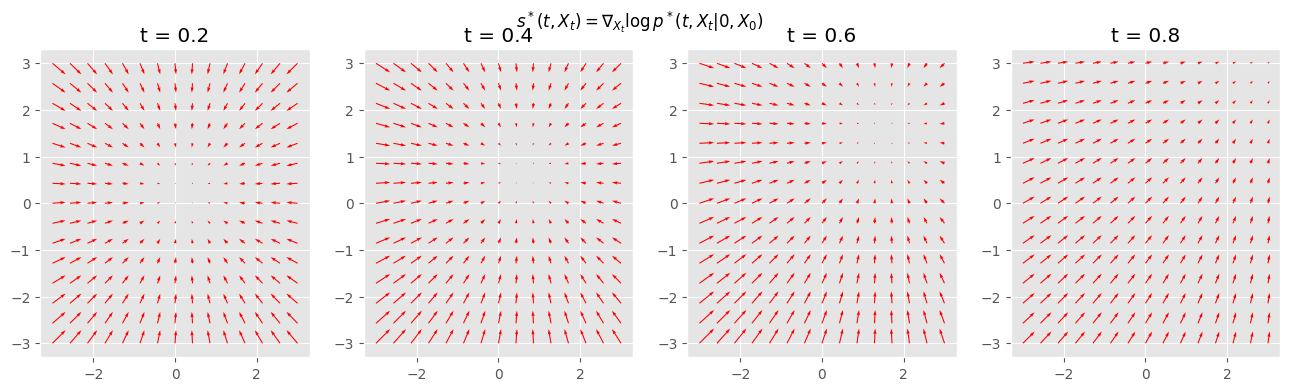

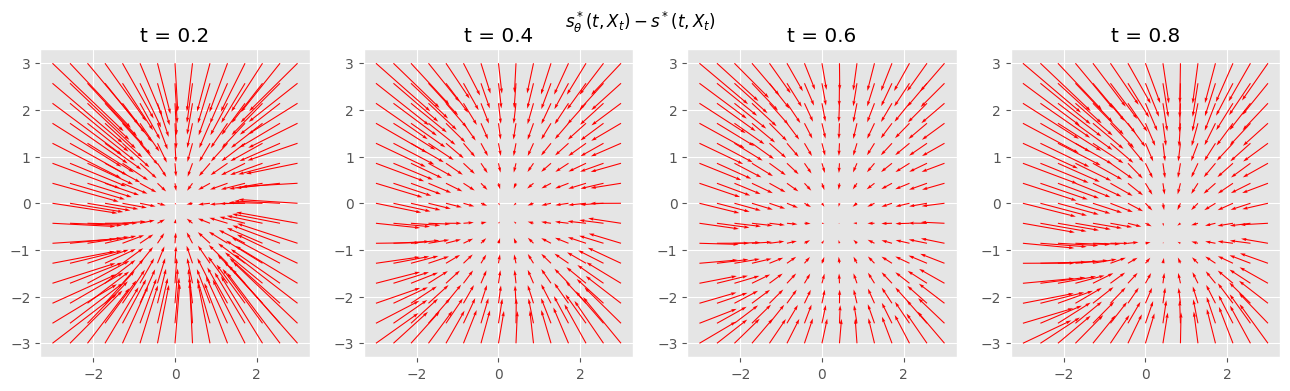

In [14]:
plot_2d_vector_field(X=lambda x, t: eval_score(score_p_star_state, x, t),
                     X_ref=None,
                     xs=jnp.linspace(-3.0, 3.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s^*_{\theta}(t, X_t)=\nabla_{X_t}\log p^*_{\theta}(t, X_t|0, X_0)$")

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0, xT, T: (xT-x0) / (T-t) - (x-x0) / t,
                     xs=jnp.linspace(-3.0, 3.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s^*(t, X_t)=\nabla_{X_t}\log p^*(t,X_t|0,X_0)$",
                     x0=jnp.array([0.0, 0.0]),
                     xT=jnp.array([1.0, 1.0]),
                     T=1.0)

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0, xT, T: eval_score(score_p_star_state, x, t) - (xT-x0) / (T-t) - (x-x0) / t,
                     xs=jnp.linspace(-3.0, 3.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s^*_{\theta}(t, X_t) - s^*(t, X_t)$",
                     scale=200,
                     x0=jnp.array([0.0, 0.0]),
                     xT=jnp.array([1.0, 1.0]),
                     T=1.0)

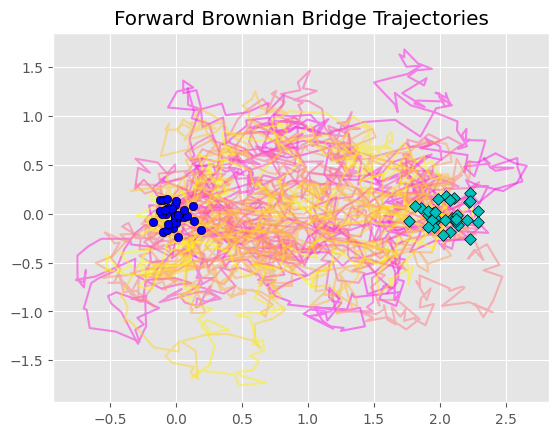

In [15]:
score_h = jax.tree_util.Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)), 
                                                         terminal_val=jnp.tile(jnp.array([[2.0, 0.0]]), reps=(32, 1)),
                                                         score_h=score_h,
                                                         rng=rng)
plot_2d_trajectories(forward_brownian_bridge["trajectories"], title="Forward Brownian Bridge Trajectories")

### Higher dimension

In [17]:
d = 32
sde = BrownianSDE(dimension=d, num_steps=100)
bridge = DiffusionBridge(sde=sde)

(32,) (32,)


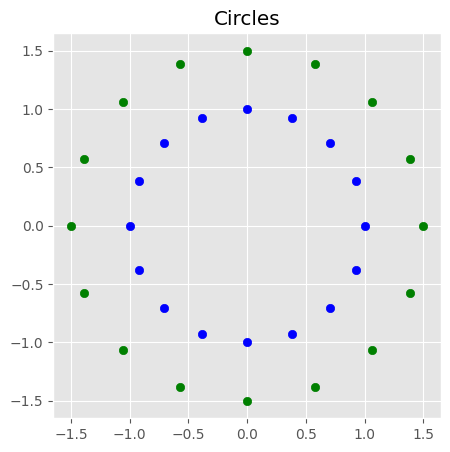

In [18]:
circles1 = sample_circle(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]))
circles2 = sample_circle(num_points=d//2, scale=1.5, shifts=jnp.array([0.0, 0.0]))
# squares = sample_square(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(circles1.reshape(-1, 2)[:, 0], circles1.reshape(-1, 2)[:, 1], color='b')
# ax.scatter(squares.reshape(-1, 2)[:, 0], squares.reshape(-1, 2)[:, 1], color='r')
ax.scatter(circles2.reshape(-1, 2)[:, 0], circles2.reshape(-1, 2)[:, 1], color='g')
ax.set_title("Circles")
print(circles1.shape, circles2.shape)

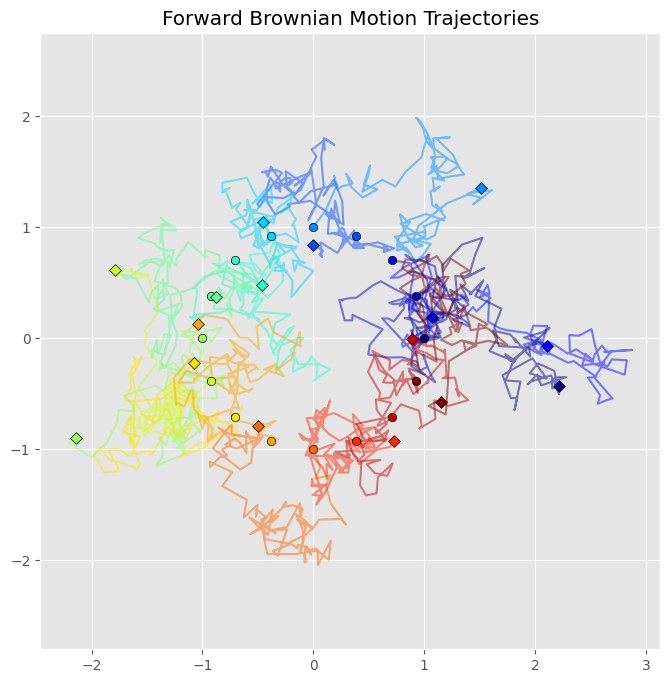

In [19]:
forward_brownian_motion = bridge.simulate_forward_process(initial_val=jnp.tile(circles1, reps=(1, 1)), rng=rng)
plot_single_trajectory(forward_brownian_motion["trajectories"][0], title="Forward Brownian Motion Trajectories")

In [20]:
setup_params = {
    "network": {"out_dim": sde.d,
                "time_embedding_dim": 128,
                "embedding_dim": 128,
                "act": 'gelu',
                "encoder_layer_dims": [128, 128],
                "decoder_layer_dims": [128, 128],
                "using_batchnorm": False},
    "training": {"batch_size": 64,
                 "num_epochs": 30,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_state = bridge.learn_p_score(initial_val=circles1, 
                                     setup_params=setup_params,
                                     rng=rng)

Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

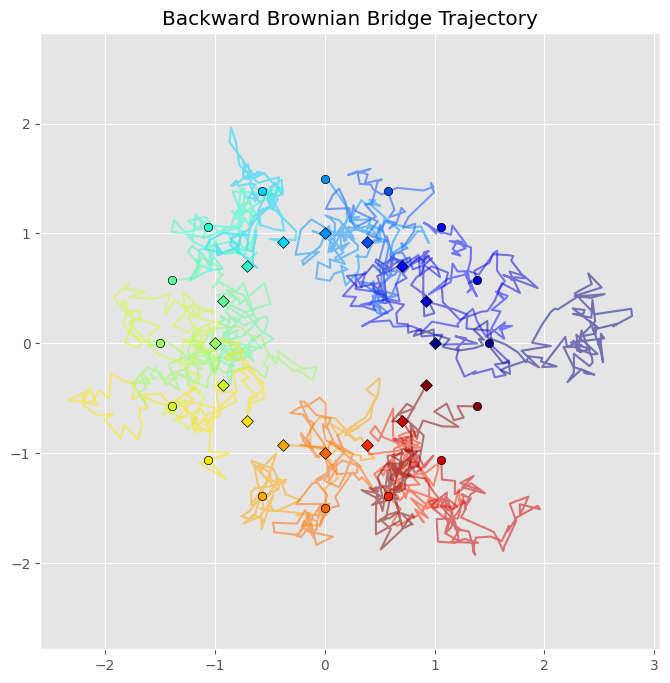

In [21]:
score_p = jax.tree_util.Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=jnp.tile(circles1, reps=(32, 1)), 
                                                           terminal_val=jnp.tile(circles2, reps=(32, 1)),
                                                           score_p=score_p,
                                                           rng=rng)
plot_single_trajectory(backward_brownian_bridge["trajectories"][0], title="Backward Brownian Bridge Trajectory")

In [22]:
setup_params = {
    "network": {"out_dim": sde.d,
                "time_embedding_dim": 128,
                "embedding_dim": 128,
                "act": 'gelu',
                "encoder_layer_dims": [128, 128],
                "decoder_layer_dims": [128, 128],
                "using_batchnorm": False},
    "training": {"batch_size": 64,
                 "num_epochs": 30,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=circles1,
                                               terminal_val=circles2,
                                               score_p=score_p,
                                               setup_params=setup_params,
                                               rng=rng)

Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

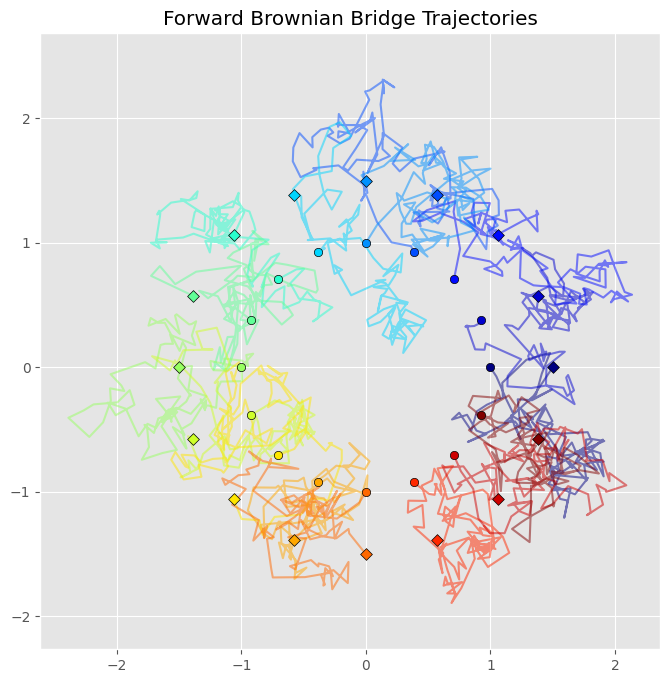

In [43]:
rng, _ = jax.random.split(rng)
score_h = jax.tree_util.Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=jnp.tile(circles1, reps=(1, 1)), 
                                                         terminal_val=jnp.tile(circles2, reps=(1, 1)),
                                                         score_h=score_h,
                                                         rng=rng)
plot_single_trajectory(forward_brownian_bridge["trajectories"][0], title="Forward Brownian Bridge Trajectories")